# 01. Data Management (Pipeline)

In [2]:
# Import modules
from pathlib import Path
import os
import geopandas as gpd
import glob
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import rasterstats
from rasterio.plot import show
import re
from fuzzywuzzy import process, fuzz
from sklearn.impute import KNNImputer, SimpleImputer
import xlrd
import openpyxl
import re
import string
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords



In [3]:
# papermill parameters cell
OUTPUT_WARNINGS = False
SAVE_INTERIMDATA = True
FILL_NAN_W_0 = False
FILL_NAN_W_KNN = True

In [4]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

### Data

In [5]:
# Data folders
RAW_FOLDER = "data/raw/"
INTERIM_FOLDER = "data/interim/"
ADMBOUND_RAW_FOLDER = "data/raw/AdmBound_rawdata/"
ADMBOUND_INTERIM_FOLDER = 'data/interim/AdmBound_interimdata/' 
ECR4_TEMPORAL_FOLDER = "data/interim/ECR4_temporaldata/"
ECR5_TEMPORAL_FOLDER = "data/interim/ECR5_temporaldata/"
W2_RAW_FOLDER = "data/raw/W2_rawdata/"
W3_RAW_FOLDER = "data/raw/W3_rawdata/"
DEMOGRAPHIC_RAW_FOLDER = "data/raw/demographic_rawdata/"
INTERIM_DEMOGRAPHIC_FOLDER = "data/interim/demographic_interimdata/"

# create folders if not exists
Path(RAW_FOLDER).mkdir(parents=True, exist_ok=True)
Path(INTERIM_FOLDER).mkdir(parents=True, exist_ok=True)
Path(ADMBOUND_RAW_FOLDER).mkdir(parents=True, exist_ok=True)
Path(ADMBOUND_INTERIM_FOLDER).mkdir(parents=True, exist_ok=True)
Path(ECR4_TEMPORAL_FOLDER).mkdir(parents=True, exist_ok=True)
Path(ECR5_TEMPORAL_FOLDER).mkdir(parents=True, exist_ok=True)
Path(W2_RAW_FOLDER).mkdir(parents=True, exist_ok=True)
Path(W3_RAW_FOLDER).mkdir(parents=True, exist_ok=True)
Path(DEMOGRAPHIC_RAW_FOLDER).mkdir(parents=True, exist_ok=True)
Path(INTERIM_DEMOGRAPHIC_FOLDER).mkdir(parents=True, exist_ok=True)

In [6]:
# Datasets KPI
ADMBOUND_RAWDATA_GML = ADMBOUND_RAW_FOLDER + 'au_AdministrativeUnit_4thOrder0.gml'
ADMBOUND_INTERIMDATA = INTERIM_FOLDER + 'AdmBound_interimdata/AdmBound_interimdata.shp'
POP21_RAWDATA = RAW_FOLDER + 'POP21_rawdata.xlsx'
POP21_INTERIMDATA = INTERIM_FOLDER + 'POP21_interimdata.csv'
D1_RAWDATA = RAW_FOLDER + 'D1_rawdata.xlsx'
D2_RAWDATA = RAW_FOLDER + 'D2_rawdata.xlsx'
D3_RAWDATA = RAW_FOLDER + 'D3_rawdata.xlsx'
D4_RAWDATA = RAW_FOLDER + 'D4_rawdata.xlsx'
ECR1_RAWDATA = RAW_FOLDER + 'ECR1_rawdata.xlsx'
ECR1_INTERIMDATA = INTERIM_FOLDER + 'ECR1_interimdata.csv'
ECR2_RAWDATA = RAW_FOLDER + 'ECR2_rawdata.xlsx'
ECR4_RAWDATA = RAW_FOLDER + 'ECR4_rawdata.tif'
ECR5_RAWDATA = RAW_FOLDER + 'ECR5_rawdata.tif'
M1_RAWDATA = RAW_FOLDER + 'M1_rawdata.csv'
M2_RAWDATA = RAW_FOLDER + 'M2_rawdata.csv'
M3_RAWDATA = RAW_FOLDER + 'M3_rawdata.csv'
M4_RAWDATA = RAW_FOLDER + 'M4_rawdata.csv'

# Datasets Demographic features
INCOME_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'INCOME_rawdata.xlsx'
DEMOGRAPHIC_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'DEMOGRAPHIC_rawdata.xlsx'
GINI_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'GINI_rawdata.xlsx'
DEM_GROWTH_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'DEM_GROWTH_rawdata.xlsx'
ECONOMIC_COMPANY_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'ECONOMIC_COMPANY_rawdata.xlsx'
TOURISM_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'TOURISM_rawdata.xls'
DEBT_MUNICIPALITY_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'DEBT_MUNICIPALITY_rawdata.xlsx'
POP_GENDER_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'POP_GENDER_rawdata.xlsx'
RESIDENTIAL_BUILDINGS_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'RESIDENTIAL_BUILDINGS_rawdata.xlsx'
TOURIST_HOUSES_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'TOURIST_HOUSES_rawdata.xlsx'
UNEMPLOYMENT_BENEFITS_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'UNEMPLOYMENT_BENEFITS_rawdata.xlsx'
AGRICULTURE_RAWDATA = DEMOGRAPHIC_RAW_FOLDER + 'AGRICULTURE_rawdata.xlsx'


# PART 1 - GENERAL MUNICIPAL DATA

## Administrative Boundaries

In [ ]:
# read as GeoDataFrame
shp_municipality = gpd.read_file(ADMBOUND_RAWDATA_GML)

In [ ]:
# Define Autonomous Community Code (CAUC), Province Code (CPRO), and Municipality Code (CMUN)
shp_municipality['CAUC'] = shp_municipality['nationalCode'].astype("string").apply(lambda x : x[2:4])
shp_municipality['CPRO'] = shp_municipality['nationalCode'].astype("string").apply(lambda x : x[6:8])
shp_municipality['CMUN'] = shp_municipality['nationalCode'].astype("string").apply(lambda x : x[8:])

# Define total code for Municipality (CTOT)
shp_municipality['CTOT'] = shp_municipality['CAUC'] + shp_municipality['CPRO'] + shp_municipality['CMUN']

In [ ]:
# filter columns
shp_municipality = shp_municipality[[
 'CTOT',
 'text',
 'geometry']]

# create a dictionary
# key = old name
# value = new name
dict = {'text': 'Municipality'}
 
# call rename () method
shp_municipality.rename(columns=dict,
          inplace=True)

In [ ]:
# Data homogenalization - Title case to all column names
shp_municipality['Municipality'] = shp_municipality['Municipality'].str.title()

In [ ]:
# Data validation - check if each municipality has its own code
ids = shp_municipality['Municipality']
shp_municipality[ids.isin(ids[ids.duplicated()])].sort_values("Municipality")

,CTOT,Municipality,geometry
1595,1328015,Arroyomolinos,"MULTIPOLYGON (((-3.94339 40.26189, -3.94356 40..."
8027,1110023,Arroyomolinos,"MULTIPOLYGON (((-6.21206 39.13186, -6.20621 39..."
324,1012033,Cabanes,"MULTIPOLYGON (((0.01701 40.14258, 0.01854 40.1..."
6675,0917030,Cabanes,"MULTIPOLYGON (((2.94356 42.33169, 2.94463 42.3..."
6003,1531070,Castejón,"MULTIPOLYGON (((-1.71989 42.13344, -1.70454 42..."
5441,0816067,Castejón,"MULTIPOLYGON (((-2.58086 40.38201, -2.58168 40..."
7491,1430019,Cieza,"MULTIPOLYGON (((-1.58950 38.30990, -1.58287 38..."
2479,0639021,Cieza,"MULTIPOLYGON (((-4.18685 43.19150, -4.18700 43..."
4678,0747031,El Campillo,"MULTIPOLYGON (((-5.04180 41.25378, -5.03385 41..."
874,0121018,El Campillo,"MULTIPOLYGON (((-6.79604 37.70071, -6.79576 37..."


In [ ]:
# exports the dataframe into Shapefile and GeoPackage file with
file_name = 'AdmBound_interimdata' 
data_format_shp = '.shp'
data_format_gpkg = '.gpkg'

export_name = file_name

if SAVE_INTERIMDATA is True:
    shp_municipality.to_file(ADMBOUND_INTERIM_FOLDER + export_name + data_format_shp)
    shp_municipality.to_file(ADMBOUND_INTERIM_FOLDER + export_name + data_format_gpkg)

FileNotFoundError: [Errno 2] No such file or directory: 'data/interim/AdmBound_temporaldata/'

## Population Register

In [ ]:
# read the raw excel file and merge all sheets into dataframe
excelFile = pd.ExcelFile(POP21_RAWDATA)
df = pd.concat(pd.read_excel(excelFile, sheet_name=None), ignore_index=True)

In [ ]:
# Replace column headers with second row and drop first two rows
df.columns = df.iloc[1]
df = df[2:]

# Create column for Municipality Code Total (CTOT)
df['CTOT'] = df['CPRO'].astype('str') + df['CMUN'].astype('str')

In [ ]:
# filter columns that refer to municipality name and population
df = df[[
 'CTOT',
 'POB21']]

# create a dictionary
# key = old name
# value = new name
dict = {'CTOT':'CMUN',
    'POB21': 'POP21'}
 
# call rename () method
df.rename(columns=dict,
          inplace=True)

In [ ]:
# exports the dataframe into csv file with
file_name = 'POP21_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df.to_csv(INTERIM_FOLDER + export_name, index=False)

# PART 2 - KPI DATA

## D1

In [ ]:
# read the raw excel file from the url
excelFile = pd.ExcelFile(D1_RAWDATA)
df = pd.read_excel(excelFile, 'EELL')

In [ ]:
# Clean datasets
# Remove first 5 rows
df.drop(df.index[:5], inplace=True)

# Drop rows where municipality is nan
df = df[df['Unnamed: 3'].notna()]

# Data Homogenization 
# Remove first 3 characters and last 1 characters from CMUN
df['CMUN'] = df['Unnamed: 3'].str.replace('L', '').str[2:].str[:-1]

# Add 1 to all municipalities that are in list
df['D1'] = 1

# Select columns
df = df[[
 'CMUN',
 'D1']]

# drop duplicate rows
df = df.drop_duplicates(subset=['CMUN'], keep='first')

In [ ]:
# read Shapefiles for foundation of municipality names
shp_municipality = gpd.read_file(ADMBOUND_INTERIMDATA)

# Get all CMUN codes of municipalities
shp_municipality['CMUN'] = shp_municipality['CTOT'].str[2:]

# Merge D1 dataset with all CMUN municipality dataset
df_D1_merge = df.merge(shp_municipality, how = 'right')

# filter out NaN-values and fill with 0
df_D1_merge['D1'] = df_D1_merge['D1'].fillna(0)

df_D1 = df_D1_merge[['CTOT', 'D1']]

In [ ]:
# exports the dataframe into csv file with
file_name = 'D1_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_D1.to_csv(INTERIM_FOLDER + export_name, index=False)

## D2

In [ ]:
# read the raw excel file from the url
excelFile = pd.ExcelFile(D2_RAWDATA)
df = pd.read_excel(excelFile, 'EELL')

/root/venv/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
# Clean datasets
# Remove first 5 rows
df.drop(df.index[:5], inplace=True)

# Drop rows where municipality is nan
df = df[df['Unnamed: 3'].notna()]

# Data Homogenization 
# Remove first 3 characters and last 1 characters from CMUN
df['CMUN'] = df['Unnamed: 3'].str.replace('L', '').str[2:].str[:-1]

# Select all rows with value 'CLAVE' (Cl@ve)
df = df[df['Servicios de la SGAD. Organismos Usuarios   (actualización diaria). Administración Local'] == 'CLAVE']

# Give value 1 to all rows that are selected
df['D2'] = 1

# Select columns
df = df[[
 'CMUN',
 'D2']]

# drop duplicate rows
df = df.drop_duplicates(subset=['CMUN'], keep='first')

In [ ]:
# read Shapefiles for foundation of municipality names
shp_municipality = gpd.read_file(ADMBOUND_INTERIMDATA)

# Get all CTOT codes of municipalities
shp_municipality['CMUN'] = shp_municipality['CTOT'].str[2:]

# Merge D2 with CMUN municipality dataset
df_D2_merge = df.merge(shp_municipality, how = 'right')

# filter out NaN-values and fill with 0
df_D2_merge['D2'] = df_D2_merge['D2'].fillna(0)

df_D2 = df_D2_merge[['CTOT', 'D2']]

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
# exports the dataframe into csv file with
file_name = 'D2_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_D2.to_csv(INTERIM_FOLDER + export_name, index=False)

/tmp/ipykernel_180/4061922068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Municipality'] = df['Municipality'].str.replace('Ayuntamiento De ', '').str.title()


## D3

In [ ]:
# read the raw excel file from the url
excelFile = pd.ExcelFile(D3_RAWDATA)
df = pd.read_excel(excelFile, 'Municipio')

In [ ]:
# Add extra digit to CMUN if it contains less than 5 characters
df['CMUN'] = df['CMUN'].apply(lambda x: '{0:0>5}'.format(x))

In [ ]:
# filter columns that refer to 'cobertura 30Mpbs' (see leyenda)
df = df[[
 'CMUN',
 'Cob. 30Mbps\n(junio 2021)']]

# create a dictionary
dict = {'Cob. 30Mbps\n(junio 2021)': 'D3'}
 
# call rename () method
df.rename(columns=dict,
          inplace=True)

In [ ]:
# exports the dataframe into csv file with
file_name = 'D3_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df.to_csv(INTERIM_FOLDER + export_name, index=False)

## D4

In [ ]:
# read the raw excel file from the url
excelFile = pd.ExcelFile(D4_RAWDATA)
df = pd.read_excel(excelFile, 'EELL')

In [ ]:
# Clean datasets
# Remove first 5 rows
df.drop(df.index[:5], inplace=True)

# Drop rows where municipality is nan
df = df[df['Unnamed: 3'].notna()]

# Select all rows with value 'Ayuntamiento'
df = df[df['Unnamed: 4'].str.contains('Ayuntamiento')==True]

# Data Homogenization 
# Remove first 3 characters and last 1 characters from CMUN
df['CMUN'] = df['Unnamed: 3'].str.replace('L', '').str[2:].str[:-1]

# Copy column
df['Services'] = df['Servicios de la SGAD. Organismos Usuarios   (actualización diaria). Administración Local']

# Select all rows without value 'SIA' or 'CLAVE' (Cl@ve)
df = df[df["Services"].str.contains('SIA|CLAVE')==False]

# Give value (1/total of unique service) to all rows that are selected
df['D4_service'] = 1/(df['Services'].nunique())

# Drop rows with double values for both CMUN and type of Services
df = df.drop_duplicates(subset=['CMUN', 'Services'], keep='last')

# Sum values of D4 per CMUN
df['D4'] = df.groupby(['CMUN'])['D4_service'].transform('sum')

# Select columns
df = df[[
 'CMUN',
 'D4']]

# drop duplicate rows
df = df.drop_duplicates(subset=['CMUN'], keep='first')

In [ ]:
# read Shapefiles for foundation of municipality names
shp_municipality = gpd.read_file(ADMBOUND_INTERIMDATA)

# Get all CTOT codes of municipalities
shp_municipality['CMUN'] = shp_municipality['CTOT'].str[2:]

# Merge D4 with CMUN municipality dataset
df_D4_merge = df.merge(shp_municipality, how = 'right')

# filter out NaN-values and fill with 0
df_D4_merge['D4'] = df_D4_merge['D4'].fillna(0)

df_D4 = df_D4_merge[['CTOT', 'D4']]

In [ ]:
# exports the dataframe into csv file with
file_name = 'D4_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_D4.to_csv(INTERIM_FOLDER + export_name, index=False)

## ECR1 & ECR2

In [7]:
# read the raw excel file from the raw folder
excel_file = ECR1_RAWDATA
df = pd.read_excel(excel_file)

In [8]:
# Data cleaning
# filter columns that refer to 'Signatories'
df = df[['Signatories']]

# create a dictionary
dict = {'Signatories': 'Municipality'}
 
# call rename () method
df.rename(columns=dict,
          inplace=True)

# Data Homogenization 
# remove 'ES' from values and title-format to values
df['Municipality'] = df['Municipality'].str.replace(r', ES', '').str.title()

In [9]:
# read the ECR2_RAWDATA excel file per sheet
df_adaption = pd.read_excel(ECR2_RAWDATA, 'Commitment - Adaption')
df_2020 = pd.read_excel(ECR2_RAWDATA, 'Commitment - 2020')
df_2030 = pd.read_excel(ECR2_RAWDATA, 'Commitment - 2030')
df_2050 = pd.read_excel(ECR2_RAWDATA, 'Commitment - 2050')

In [10]:
# filter to municipality name and change values to title-format
df_adaption = df_adaption['Signatories'].str.title()
df_2020 = df_2020['Signatories'].str.title()
df_2030 = df_2030['Signatories'].str.title()
df_2050 = df_2050['Signatories'].str.title()

In [11]:
# Create new columns, based on each seperate dataframe per level of commitment
df['Commitment_Adaption'] = df['Municipality'].apply(lambda str: any([(reqWord in str) for reqWord in df_adaption]))
df['Commitment_2020'] = df['Municipality'].apply(lambda str: any([(reqWord in str) for reqWord in df_2020]))
df['Commitment_2030'] = df['Municipality'].apply(lambda str: any([(reqWord in str) for reqWord in df_2030]))
df['Commitment_2050'] = df['Municipality'].apply(lambda str: any([(reqWord in str) for reqWord in df_2050]))

In [12]:
# Assign value to all municipalities in list by creating condition for dataset merging later on
    #['Commitment_Adaption'] = 0.1
    #['Commitment_2020'] = 0.3
    #['Commitment_2030'] = 0.6
    #['Commitment_2050'] = 0.9

conditions_Adaption = [
    (df['Commitment_Adaption'] == True),
    (df['Commitment_Adaption'] == False)] 

conditions_2020 = [
    (df['Commitment_2020'] == True),
    (df['Commitment_2020'] == False)]    

conditions_2030 = [
    (df['Commitment_2030'] == True),
    (df['Commitment_2030'] == False)]  

conditions_2050 = [
    (df['Commitment_2050'] == True),
    (df['Commitment_2050'] == False)]  

# Create a list of values that must be assigned when condition is true or false
values_Adaption = [1, 0]
values_2020 = [2, 0]
values_2030 = [4, 0]
values_2050 = [10, 0]

# Create new column with binary assigning
df['Commitment_Adaption_Score'] = np.select(conditions_Adaption, values_Adaption)
df['Commitment_2020_Score'] = np.select(conditions_2020, values_2020)
df['Commitment_2030_Score'] = np.select(conditions_2030, values_2030)
df['Commitment_2050_Score'] = np.select(conditions_2050, values_2050)

# Sum of all scores to new total score in Column
df['ECR2'] =  df['Commitment_Adaption_Score'] + df['Commitment_2020_Score'] + df['Commitment_2030_Score'] + df['Commitment_2050_Score']

# Maximise output score to 1
df.loc[df['ECR2'] == 1, 'ECR2'] = 0.1
df.loc[df['ECR2'] == 2, 'ECR2'] = 0.3
df.loc[df['ECR2'] == 3, 'ECR2'] = 0.4
df.loc[df['ECR2'] == 4, 'ECR2'] = 0.6
df.loc[df['ECR2'] == 5, 'ECR2'] = 0.7
df.loc[df['ECR2'] == 6, 'ECR2'] = 0.6
df.loc[df['ECR2'] == 7, 'ECR2'] = 0.7
df.loc[df['ECR2'] == 10, 'ECR2'] = 0.9
df.loc[df['ECR2'] == 11, 'ECR2'] = 1
df.loc[df['ECR2'] == 12, 'ECR2'] = 0.9
df.loc[df['ECR2'] == 13, 'ECR2'] = 1
df.loc[df['ECR2'] == 14, 'ECR2'] = 0.9
df.loc[df['ECR2'] == 15, 'ECR2'] = 1
df.loc[df['ECR2'] == 16, 'ECR2'] = 0.9
df.loc[df['ECR2'] == 17, 'ECR2'] = 1

In [13]:
# filter columns that refer to 'ECR2' 
df = df[[
 'Municipality',
 'ECR2']]

In [15]:
# read Shapefiles for foundation of municipality names
shp_municipality = gpd.read_file(ADMBOUND_INTERIMDATA)
shp_names = shp_municipality['Municipali']

In [16]:
# DATA CLEANING
# Create new column to append fuzzywuzzy to
fuzzywuzzy_ECR2 = pd.DataFrame(columns=['ECR2_name','ECR2','Match_name', 'CTOT', 'score', 'fuzzywuzzy_method'])

# Apply fuzzywuzzy to link municipality names for merging
n=0

# try fuzz.token_sort_ratio
for df_name in df['Municipality']:
    print("Search name : ", df_name, '\n', 62*'-', '\n')
    print(n, "/", len(df.axes[0]))
    
    choices = shp_names
    result = process.extract(df_name, choices, scorer=fuzz.token_sort_ratio)        

    ECR2 = df['ECR2'].iloc[n]
    match = result[0][0]
    score = result[0][1]
    index = result[0][2]
    CTOT = shp_municipality['CTOT'].iloc[index]

    if score > 90:
        new_row = {'ECR2_name':df_name, 
                    'ECR2':ECR2,
                    'Match_name':match,                    
                    'CTOT':CTOT,
                    'score':score,
                    'fuzzywuzzy_method': 'token_sort_ratio'}

    # try fuzz.WRatio 
    else:
        result_else = process.extract(df_name, choices, scorer=fuzz.WRatio)

        match_else = result_else[0][0]
        score_else = result_else[0][1]
        index_else = result_else[0][2]
        CTOT_else = shp_municipality['CTOT'].iloc[index_else]

        if score_else > 90:
            new_row = {'ECR2_name':df_name, 
                'ECR2':ECR2,
                'Match_name':match_else,
                'CTOT':CTOT_else,
                'score':score_else,
                'fuzzywuzzy_method': 'WRatio'}

        #try fuzz.token_set_ratio --> ignores duplicated words
        else:
            result_token_set_ratio = process.extract(df_name, choices, scorer=fuzz.token_set_ratio)

            match_token_set_ratio = result_token_set_ratio[0][0]
            score_token_set_ratio = result_token_set_ratio[0][1]
            index_token_set_ratio = result_token_set_ratio[0][2]
            CTOT_token_set_ratio = shp_municipality['CTOT'].iloc[index_token_set_ratio]

            if score_token_set_ratio > 90:
                new_row = {'ECR2_name':df_name, 
                    'ECR2':ECR2,
                    'Match_name':match_token_set_ratio,
                    'score':score_token_set_ratio,
                    'CTOT':CTOT_token_set_ratio,
                    'fuzzywuzzy_method': 'token_set_ratio'}
            
            # If no score above 90, return NAN-value
            else:
                new_row = {'ECR2_name':df_name, 
                    'ECR2':ECR2,
                    'Match_name':np.NAN,                    
                    'CTOT':np.NAN,
                    'score':np.NAN,
                    'fuzzywuzzy_method': np.NAN}


    fuzzywuzzy_ECR2 = fuzzywuzzy_ECR2.append(new_row, ignore_index=True)

    n = n+1

 -------------------------------------------------------------- 

2646 / 2896
Search name :  La Tahá 
 -------------------------------------------------------------- 

2647 / 2896
Search name :  Tarifa 
 -------------------------------------------------------------- 

2648 / 2896
Search name :  Zafarraya 
 -------------------------------------------------------------- 

2649 / 2896
Search name :  Ronda 
 -------------------------------------------------------------- 

2650 / 2896
Search name :  La Carlota 
 -------------------------------------------------------------- 

2651 / 2896
Search name :  Barbate 
 -------------------------------------------------------------- 

2652 / 2896
Search name :  Marchal 
 -------------------------------------------------------------- 

2653 / 2896
Search name :  Cijuela 
 -------------------------------------------------------------- 

2654 / 2896
Search name :  Iznalloz 
 -------------------------------------------------------------- 

2655 / 2896
S

In [17]:
df_ECR2 = fuzzywuzzy_ECR2[[
 'CTOT',
 'ECR2']]

# drop duplicate rows
df_ECR2 = df_ECR2.drop_duplicates(subset=['CTOT'], keep='first')

In [18]:
# Create ECR1 out of ECR2
df_ECR1 = df_ECR2.copy()

# Assign value 'Yes' to all municipalities in list (1 = signed CoM)
df_ECR1['ECR1'] = 1

# filter columns that refer to 'Signed_CovenantofMayors_Binary'
df_ECR1 = df_ECR1[[
 'CTOT',
 'ECR1']]

In [19]:
# Get all CTOT codes of municipalities
shp_CTOT = shp_municipality['CTOT']

# Merge ECR1 and ECR2 dataset with all CTOT municipality dataset
df_ECR1_merge = df_ECR1.merge(shp_municipality, how = 'right')
df_ECR2_merge = df_ECR2.merge(shp_municipality, how = 'right')

# filter out NaN-values and fill with 0 (if municipality does not have punto limpio)
df_ECR1_merge['ECR1'] = df_ECR1_merge['ECR1'].fillna(0)
df_ECR2_merge['ECR2'] = df_ECR2_merge['ECR2'].fillna(0)

df_ECR1 = df_ECR1_merge[['CTOT', 'ECR1']]
df_ECR2 = df_ECR2_merge[['CTOT', 'ECR2']]

In [20]:
# export the ECR1 dataframe into csv file
file_name = 'ECR1_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_ECR1.to_csv(INTERIM_FOLDER + export_name, index=False)

In [21]:
# export the ECR2 dataframe into csv file
file_name = 'ECR2_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_ECR2.to_csv(Path(INTERIM_FOLDER) / export_name, index=False)

## ECR4

In [ ]:
# create path for temporal dataset
ECR4_TEMPORALDATA = ECR4_TEMPORAL_FOLDER + "interim_PM10_avg19.tif"

# replace nodata value raster
with rasterio.open(ECR4_RAWDATA, "r+") as src:
    src.nodata = 0 # set the nodata value
    profile = src.profile
    profile.update(
            dtype=rasterio.uint8,
            compress='lzw'
    )

    with rasterio.open(ECR4_TEMPORALDATA, 'w',  **profile) as dst:
        for i in range(1, src.count + 1):
            band = src.read(i)
            # band = np.where(band!=1,0,band) # if value is not equal to 1 assign no data value i.e. 0
            band = np.where(band==0,0,band) # for completeness
            dst.write(band,i)

In [ ]:
# read shapefile Administrative Boundaries Spain
boundaries = gpd.read_file(ADMBOUND_INTERIMDATA)
print(boundaries.crs)

epsg:4258


In [ ]:
# read rasterfile PM10
rf = rasterio.open(ECR4_TEMPORALDATA)

In [ ]:
# check characteristics and CRS of interim raster file
print('width =',(rf.width))
print('height =',(rf.height))
print('BoundingBox =',(rf.bounds))
print('CRS =',(rf.crs))

# change projection
CRS = rf.crs
boundaries = boundaries.to_crs(CRS)

width = 4680
height = 4037
BoundingBox = BoundingBox(left=2636000.0, bottom=1386000.000000001, right=7316000.0, top=5423000.000000001)
CRS = EPSG:3035


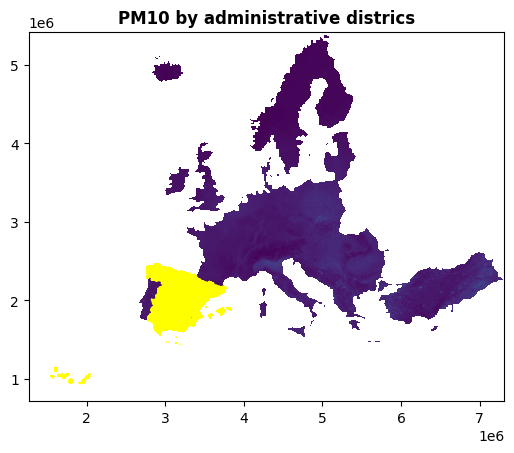

In [ ]:
# plotting rasterfile and shapefile together - to check if overlay succeeded
fig, ax = plt.subplots(1,1)
show(rf, ax=ax, title = 'PM10 by administrative districs')
boundaries.plot(ax=ax, facecolor='None', edgecolor = 'yellow')
plt.show()

In [ ]:
# Extract raster values to a numpy nd array
PM10_array = rf.read(1)
type(PM10_array)

# Transform raster
affine = rf.transform

# Get metadata
metadata = rf.meta
print('Metadata =',metadata)
print('NoData =',rf.nodata)
print('CRS =',rf.crs)

Metadata = {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 4680, 'height': 4037, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(1000.0, 0.0, 2636000.0,
       0.0, -1000.0, 5423000.000000001)}
NoData = 0.0
CRS = EPSG:3035


In [ ]:
# Calculate zonal stats
average_PM10 = rasterstats.zonal_stats(boundaries, PM10_array, affine = affine, stats = ['mean'], geojson_out = True)

In [ ]:
# Extracting PM10 values per municipality
mean_PM10 = []
i = 0

while i < len(average_PM10):
    mean_PM10.append(average_PM10[i]['properties'])
    i = i + 1

# Extracting data to dataframe
df = pd.DataFrame(mean_PM10)

In [ ]:
# Rename column headers
df['ECR4_temp'] = df['mean']

# Select only the columns with municipality name and value
df_ECR4 = df[['CTOT','ECR4_temp']]

In [ ]:
# ADD KNN IMPUTER
# Replace NaN-values with k-nearest neighbour value
if FILL_NAN_W_KNN is True:
    df_index = df_ECR4.set_index('CTOT')
    df_transformed = df_index.copy()
    df_transformed = df_transformed.values.reshape(-1, 1)
    if pd.isnull(df_transformed).sum().sum() != 0:
        knn_ECR4 = KNNImputer()
        knn_ECR4.fit(df_transformed)
        df_transformed = knn_ECR4.transform(df_transformed)
    else:
        pass

    # Extra check: if df_transformed still contains NaN-values, then replace with 'mean' value
    if pd.isnull(df_transformed).sum().sum() != 0:
        simple_y = SimpleImputer(missing_values=np.nan, strategy='mean')
        simple_y.fit(df_transformed)
        df_transformed = simple_y.transform(df_transformed)
    else: 
        pass

    # Create function to transform dataframe with index, column headers
    df_ECR4['ECR4'] = pd.DataFrame(df_transformed, columns = ['ECR4'])
    df_ECR4 = df_ECR4.drop(['ECR4_temp'], axis=1)

In [ ]:
# exports the dataframe into csv file with
file_name = 'ECR4_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_ECR4.to_csv(INTERIM_FOLDER + export_name, index=False)

In [ ]:
# delete temporal folder (ECR4_TEMPORAL_FOLDER)
shutil.rmtree(ECR4_TEMPORAL_FOLDER, ignore_errors=True)

## ECR5

In [ ]:
# create path for temporal dataset
ECR5_TEMPORALDATA = ECR5_TEMPORAL_FOLDER + "nox_avg19.tif"

# replace nodata value raster
with rasterio.open(ECR5_RAWDATA, "r+") as src:
    src.nodata = 0 # set the nodata value
    profile = src.profile
    profile.update(
            dtype=rasterio.uint8,
            compress='lzw'
    )

    with rasterio.open(ECR5_TEMPORALDATA, 'w',  **profile) as dst:
        for i in range(1, src.count + 1):
            band = src.read(i)
            # band = np.where(band!=1,0,band) # if value is not equal to 1 assign no data value i.e. 0
            band = np.where(band==0,0,band) # for completeness
            dst.write(band,i)

In [ ]:
# read shapefile Administrative Boundaries Spain
boundaries = gpd.read_file(ADMBOUND_INTERIMDATA)
print('ADMBOUND_INTERIMDATA --> CRS =',(boundaries.crs))

ADMBOUND_INTERIMDATA --> CRS = epsg:4258


In [ ]:
# read rasterfile NOx
rf = rasterio.open(ECR5_TEMPORALDATA)

In [ ]:
# check interim raster file
print('width =',(rf.width))
print('height =',(rf.height))
print('BoundingBox =',(rf.bounds))
print('CRS =',(rf.crs))

# change projection
CRS = rf.crs
boundaries = boundaries.to_crs(CRS)

width = 2395
height = 2070
BoundingBox = BoundingBox(left=2549999.999999998, bottom=1360000.0000000019, right=7339999.999999998, top=5500000.000000002)
CRS = EPSG:3035


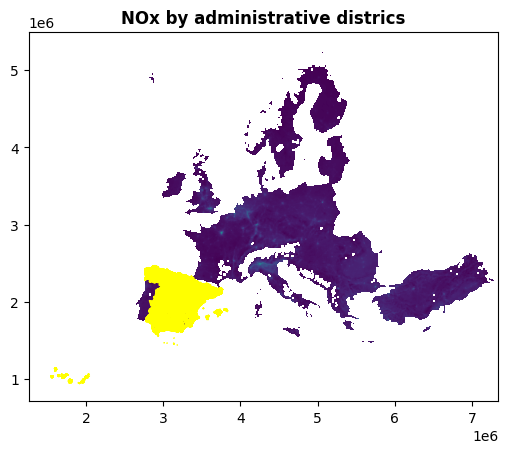

In [ ]:
# plotting rasterfile and shapefile together - to check if overlay succeeded
fig, ax = plt.subplots(1,1)
show(rf, ax=ax, title = 'NOx by administrative districs')
boundaries.plot(ax=ax, facecolor='None', edgecolor = 'yellow')
plt.show()

In [ ]:
# Extract raster values to a numpy nd array
NOx_array = rf.read(1)
type(NOx_array)

# Transform raster
affine = rf.transform

# Get metadata
metadata = rf.meta
print('Metadata =',metadata)
print('NoData =',rf.nodata)
print('CRS =',rf.crs)

Metadata = {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2395, 'height': 2070, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(2000.0, 0.0, 2549999.999999998,
       0.0, -2000.0, 5500000.000000002)}
NoData = 0.0
CRS = EPSG:3035


In [ ]:
# Calculate zonal stats
average_NOx = rasterstats.zonal_stats(boundaries, NOx_array, affine = affine, stats = ['mean'], geojson_out = True)

In [ ]:
# Extracting NOx values per municipality
mean_NOx = []
i = 0

while i < len(average_NOx):
    mean_NOx.append(average_NOx[i]['properties'])
    i = i + 1

# Extracting data to dataframe
df = pd.DataFrame(mean_NOx)

In [ ]:
# Rename column headers
df['ECR5_temp'] = df['mean']

# Select only the columns with municipality name and value
df_ECR5 = df[['CTOT','ECR5_temp']]

In [ ]:
# ADD KNN IMPUTER
# Replace NaN-values with k-nearest neighbour value
if FILL_NAN_W_KNN is True:
    df_index = df_ECR5.set_index('CTOT')
    df_transformed = df_index.copy()
    df_transformed = df_transformed.values.reshape(-1, 1)
    if pd.isnull(df_transformed).sum().sum() != 0:
        knn_ECR5 = KNNImputer()
        knn_ECR5.fit(df_transformed)
        df_transformed = knn_ECR5.transform(df_transformed)
    else:
        pass

    # Extra check: if df_transformed still contains NaN-values, then replace with 'mean' value
    if pd.isnull(df_transformed).sum().sum() != 0:
        simple_y = SimpleImputer(missing_values=np.nan, strategy='mean')
        simple_y.fit(df_transformed)
        df_transformed = simple_y.transform(df_transformed)
    else: 
        pass

    # Create function to transform dataframe with index, column headers
    df_ECR5['ECR5'] = pd.DataFrame(df_transformed, columns = ['ECR5'])
    df_ECR5 = df_ECR5.drop(['ECR5_temp'], axis=1)

In [ ]:
# exports the dataframe into csv file with
file_name = 'ECR5_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_ECR5.to_csv(INTERIM_FOLDER + export_name, index=False)

In [ ]:
# delete temporal folder (ECR5_TEMPORAL_FOLDER)
#shutil.rmtree(ECR5_TEMPORAL_FOLDER, ignore_errors=False, onerror=None)

OSError: [Errno 39] Directory not empty: 'data/interim/ECR5_temporaldata/'

## M1

In [ ]:
# read datasets into dataframe
df_M1_raw = pd.read_csv(M1_RAWDATA)
df_POP21 = pd.read_csv(POP21_INTERIMDATA)

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/M1_rawdata.csv'

In [ ]:
# DATA HOMOGENIZATION
# Add extra digit to CCI POP21 CMUN - if it contains less than 5 characters
df_POP21['CMUN'] = df_POP21['CMUN'].apply(lambda x: '{0:0>5}'.format(x))

# Add extra digit to CCI M1 CTOT - if it contains less than 7 characters
df_M1_raw['CTOT'] = df_M1_raw['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Creat for CCI M1 column CMUN out of CTOT
df_M1_raw['CMUN'] = df_M1_raw['CTOT'].str[2:]

In [ ]:
# Merge datasets of M1 and POP21 into one dataframe
df_M1 = df_M1_raw.merge(df_POP21, how = 'right')

In [ ]:
# create new column for relative number of pedestrian areas per 100 inhabitants
df_M1['M1'] = (df_M1['M1_surface'] / df_M1['POP21']) * 100

In [ ]:
# Replace NaN values with 0 in dataframe
if FILL_NAN_W_0 is True:
    df_M1['M1'] = df_M1['M1'].fillna(0)

if FILL_NAN_W_0 is False:
    df_M1['M1'] = df_M1['M1'].replace(0.0, np.nan, inplace=False)

# filter columns that refer to KPIs
df_M1 = df_M1[[
    'CMUN', 
    'M1']]

In [ ]:
# exports the dataframe into csv file
file_name = 'M1_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_M1.to_csv((INTERIM_FOLDER) + export_name, index=False)

## M2

In [ ]:
# read datasets into dataframe
df_M2_raw = pd.read_csv(M2_RAWDATA)
df_POP21 = pd.read_csv(POP21_INTERIMDATA)

In [ ]:
# DATA HOMOGENIZATION
# Add extra digit to CCI POP21 CMUN - if it contains less than 5 characters
df_POP21['CMUN'] = df_POP21['CMUN'].apply(lambda x: '{0:0>5}'.format(x))

# Add extra digit to CCI M2 CTOT - if it contains less than 7 characters
df_M2_raw['CTOT'] = df_M2_raw['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Creat for CCI M2 column CMUN out of CTOT
df_M2_raw['CMUN'] = df_M2_raw['CTOT'].str[2:]

In [ ]:
# Merge datasets of M2 and POP21 into one dataframe
df_M2 = df_M2_raw.merge(df_POP21, how = 'right')

In [ ]:
# create new column for relative number of charging_stations per 1,000 inhabitants
df_M2['M2'] = (df_M2['M2_absolute'] / df_M2['POP21']) * 1000

In [ ]:
# Replace NaN values with 0 in dataframe
if FILL_NAN_W_0 is True:
    df_M2['M2'] = df_M2['M2'].fillna(0)

# Drop duplicate rows
df_M2 = df_M2.drop_duplicates(subset=['CMUN'])

# filter columns that refer to KPIs
df_M2 = df_M2[[
    'CMUN', 
    'M2']]

In [ ]:
# exports the dataframe into csv file
file_name = 'M2_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_M2.to_csv((INTERIM_FOLDER) + export_name, index=False)

## M3

In [ ]:
# read datasets into dataframe
df_M3_raw = pd.read_csv(M3_RAWDATA)
gdf_AdmBound = gpd.read_file(ADMBOUND_INTERIMDATA)

In [ ]:
# DATA HOMOGENIZATION
# Add extra digit to CCI M3 CTOT - if it contains less than 7 characters
df_M3_raw['CTOT'] = df_M3_raw['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Creat for CCI M3 column CMUN out of CTOT
df_M3_raw['CMUN'] = df_M3_raw['CTOT'].str[2:]

# Add extra digit to CCI AdmBound CTOT - if it contains less than 7 characters
gdf_AdmBound['CTOT'] = gdf_AdmBound['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Creat for CCI AdmBound column CMUN out of CTOT
gdf_AdmBound['CMUN'] = gdf_AdmBound['CTOT'].str[2:]

In [ ]:
# Change projection to measure in meters
gdf_AdmBound = gdf_AdmBound.to_crs(epsg=2062)

# create new column for surface of municipality in km2
gdf_AdmBound['Mun_Surface_km2'] = gdf_AdmBound['geometry'].area / 1000**2

In [ ]:
# Merge datasets of M3 and AdmBound into one dataframe
df_M3 = df_M3_raw.merge(gdf_AdmBound, how = 'right')

In [ ]:
# create new column for relative length of cycleways per 100 km2
df_M3['M3'] = (df_M3['M3_length'] / df_M3['Mun_Surface_km2']) * 100

In [ ]:
# Replace NaN values with 0 in dataframe
if FILL_NAN_W_0 is True:
    df_M3['M3'] = df_M3['M3'].fillna(0)

# filter columns that refer to KPIs
df_M3 = df_M3[[
    'CMUN', 
    'M3']]

In [ ]:
# exports the dataframe into csv file
file_name = 'M3_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_M3.to_csv((INTERIM_FOLDER) + export_name, index=False)

## M4

In [ ]:
# read datasets into dataframe
df_M4_raw = pd.read_csv(M4_RAWDATA)
df_POP21 = pd.read_csv(POP21_INTERIMDATA)

In [ ]:
# DATA HOMOGENIZATION
# Add extra digit to CCI POP21 CMUN - if it contains less than 5 characters
df_POP21['CMUN'] = df_POP21['CMUN'].apply(lambda x: '{0:0>5}'.format(x))

# Add extra digit to CCI M4 CTOT - if it contains less than 7 characters
df_M4_raw['CTOT'] = df_M4_raw['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Creat for CCI M2 column CMUN out of CTOT
df_M4_raw['CMUN'] = df_M4_raw['CTOT'].str[2:]

In [ ]:
# Merge datasets of M4 and POP21 into one dataframe
df_M4 = df_M4_raw.merge(df_POP21, how = 'right')

In [ ]:
# create new column for relative number of bus_stops per 100 inhabitants
df_M4['M4'] = (df_M4['M4_absolute'] / df_M4['POP21']) * 100

In [ ]:
# Replace NaN values with 0 in dataframe
if FILL_NAN_W_0 is True:
    df_M4['M4'] = df_M4['M4'].fillna(0)

# Drop duplicate rows
df_M4 = df_M4.drop_duplicates(subset=['CMUN'])

# filter columns that refer to KPIs
df_M4 = df_M4[[
    'CMUN', 
    'M4']]

In [ ]:
# exports the dataframe into csv file
file_name = 'M4_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_M4.to_csv((INTERIM_FOLDER) + export_name, index=False)

## W2

In [ ]:
# excel files in the path
file_list = glob(W2_RAW_FOLDER + "/*.xlsx")

# list of excel files we want to merge data into pandas dataframe.
excl_list = []

In [ ]:
for file in file_list:  
    df = pd.read_excel(file)
    excl_list.append(df)

In [ ]:
# create a new dataframe to store the merged excel file.
excl_merged = pd.DataFrame()

# appends the data into the excl_merged 
for excl_file in excl_list:
        
    excl_merged = excl_merged.append(
      excl_file, ignore_index=True)

In [ ]:
# filter columns that refer to municipality name and kilograms waste
df = excl_merged[[
 'Municipio',
 'Envases de vidrio (kgs) recogidos']]

# create a dictionary
# key = old name
# value = new name
dict = {'Municipio': 'Municipality',
        'Envases de vidrio (kgs) recogidos': 'W2'}
 
# call rename () method
df.rename(columns=dict,
          inplace=True)

# data cleaning of summed up rows per seperate table
df = df.drop(df.index[df['Municipality'] == "TOTAL"])

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
# DATA HOMOGENIALIZATION 
# Title case to all column names
df['Municipality'] = df['Municipality'].str.title()

# Split municipality names into core name and preposition by comma
df[['MUN_name', 'MUN_preposition']] = df['Municipality'].str.split(',', expand=True)

# Fill None-value (municipalities without preposition) with empty
df = pd.DataFrame(df)
df = df.fillna('')

In [ ]:
# DATA CLEANING
preposition = ["Es", "La", "El", "Las", "Els", "Los", "A", "O", "Os", "As", "Les", "Sa", "Ses"]

# Replace preposition before municipality name
for index, item in enumerate(df['MUN_preposition']):
    try:
        if df['MUN_preposition'][index] == "L'":
            df['Municipality'][index] = df['MUN_preposition'][index] + df['MUN_name'][index]
            df['MUN_preposition'][index] == ''
        elif df['MUN_preposition'][index] in preposition:
            df['Municipality'][index] = df['MUN_preposition'][index]  + df['MUN_name'][index]
            df['MUN_preposition'][index] = ''
        else:
            pass
    except KeyError:
        pass    

In [ ]:
# Replace manually other Municipality names to be in line with administrative dataset
df['Municipality'].mask(df['Municipality'] == "Fondó De Les Neus, El/Hondón De Las Nieves", "El Fondó De Les Neus/Hondón De Las Nieves", inplace=True)
df['Municipality'].mask(df['Municipality'] == "Pinós, El/Pinoso", "El Pinós/Pinoso", inplace=True)
df['Municipality'].mask(df['Municipality'] == "Alqueries, Les/Alquerías Del Niño Perdido", "Les Alqueries/Alquerías Del Niño Perdido", inplace=True)
df['Municipality'].mask(df['Municipality'] == "Rasillo De Cameros, El", "El Rasillo De Cameros", inplace=True)
df['Municipality'].mask(df['Municipality'] == "Redal, El", "El Redal", inplace=True)
df['Municipality'].mask(df['Municipality'] == "Villar De Arnedo, El", "El Villar De Arnedo", inplace=True)


In [ ]:
# filter columns that refer to municipality name and W2-score
df = df[[
 'Municipality',
 'W2']]

In [ ]:
# read Shapefiles for foundation of municipality names
shp_municipality = gpd.read_file(ADMBOUND_INTERIMDATA)
shp_names = shp_municipality['Municipali']

In [ ]:
# Create new column to append fuzzywuzzy to
fuzzywuzzy_W2 = pd.DataFrame(columns=['W2_name','W2','Match_name', 'CTOT', 'score', 'fuzzywuzzy_method'])

# Apply fuzzywuzzy to link municipality names for merging
n=0

# try fuzz.token_sort_ratio
for df_name in df['Municipality']:
    print("Search name : ", df_name, '\n', 62*'-', '\n')
    print(n, "/", len(df.axes[0]))
    
    choices = shp_names
    result = process.extract(df_name, choices, scorer=fuzz.token_sort_ratio)        

    W2 = df['W2'].iloc[n]
    match = result[0][0]
    score = result[0][1]
    index = result[0][2]
    CTOT = shp_municipality['CTOT'].iloc[index]

    if score > 85:
        new_row = {'W2_name':df_name, 
                    'W2':W2,
                    'Match_name':match,                    
                    'CTOT':CTOT,
                    'score':score,
                    'fuzzywuzzy_method': 'token_sort_ratio'}

    # try fuzz.token_set_ratio --> ignores duplicated words
    else:
        result_else = process.extract(df_name, choices, scorer=fuzz.token_set_ratio)

        match_else = result_else[0][0]
        score_else = result_else[0][1]
        index_else = result_else[0][2]
        CTOT_else = shp_municipality['CTOT'].iloc[index_else]

        if score_else > score:
            new_row = {'W2_name':df_name, 
                'W2':W2,
                'Match_name':match_else,
                'CTOT':CTOT_else,
                'score':score_else,
                'fuzzywuzzy_method': 'token_set_ratio'}

        #try fuzz.WRatio
        else:
            result_WRatio = process.extract(df_name, choices, scorer=fuzz.WRatio)

            match_WRatio = result_WRatio[0][0]
            score_WRatio = result_WRatio[0][1]
            index_WRatio = result_WRatio[0][2]
            CTOT_WRatio = shp_municipality['CTOT'].iloc[index_WRatio]

            if score_WRatio > score:
                new_row = {'W2_name':df_name, 
                    'W2':W2,
                    'Match_name':match_WRatio,
                    'score':score_WRatio,
                    'CTOT':CTOT_WRatio,
                    'fuzzywuzzy_method': 'WRatio'}
            
            # If no score above 85, return NAN-value
            else:
                new_row = {'W2_name':df_name, 
                    'W2':W2,
                    'Match_name':np.NAN,                    
                    'CTOT':np.NAN,
                    'score':np.NAN,
                    'fuzzywuzzy_method': np.NAN}


    fuzzywuzzy_W2 = fuzzywuzzy_W2.append(new_row, ignore_index=True)

    n = n+1

Search name :  Arres 
 -------------------------------------------------------------- 

0 / 8131
Search name :  Bausen 
 -------------------------------------------------------------- 

1 / 8131
Search name :  Bòrdes, Es 
 -------------------------------------------------------------- 

2 / 8131
Search name :  Bossòst 
 -------------------------------------------------------------- 

3 / 8131
Search name :  Canejan 
 -------------------------------------------------------------- 

4 / 8131
Search name :  Les 
 -------------------------------------------------------------- 

5 / 8131
Search name :  Naut Aran 
 -------------------------------------------------------------- 

6 / 8131
Search name :  Vielha E Mijaran 
 -------------------------------------------------------------- 

7 / 8131
Search name :  Vilamòs 
 -------------------------------------------------------------- 

8 / 8131
Search name :  Melilla 
 -------------------------------------------------------------- 

9 / 8131
Sea

KeyboardInterrupt: 

In [ ]:
# filter columns that refer to municipality name and population
fuzzywuzzy_W2['W2_absolute'] = fuzzywuzzy_W2['W2']

df = fuzzywuzzy_W2[[
 'CTOT',
 'W2_absolute']]

# drop duplicate rows
df = df.drop_duplicates(subset=['CTOT'], keep='first')

,CTOT,W2_absolute
0,0925031,2677.0
1,0925045,2677.0
2,0925057,11377.0
3,0925059,49747.0
4,0925063,3971.0
...,...,...
91,0333032,161530.0
92,0333033,132100.0
93,0333035,272290.0
94,0333036,243500.0


In [ ]:
# Get all CTOT codes of municipalities
shp_CTOT = shp_municipality['CTOT']

# Merge W2 dataset with all CTOT municipality dataset
df_merge = df.merge(shp_municipality, how = 'right')

# filter out NaN-values and fill with 0 (if municipality does not have punto limpio)
df_merge['W2_absolute'] = df_merge['W2_absolute'].fillna(0)

df_W2 = df_merge[['CTOT', 'W2_absolute']]

,CTOT,W2_absolute,CMUN
0,1003124,0.0,03124
1,1003125,0.0,03125
2,1046224,0.0,46224
3,0908222,0.0,08222
4,0908223,0.0,08223
...,...,...,...
8212,1215072,0.0,15072
8213,1215073,0.0,15073
8214,1215074,0.0,15074
8215,1215075,0.0,15075


In [ ]:
# Normalize outcome to population of municipality

# read datasets into dataframe
df_POP21 = pd.read_csv(POP21_INTERIMDATA)

# Add extra digit to CCI POP21 CMUN - if it contains less than 5 characters
df_POP21['CMUN'] = df_POP21['CMUN'].apply(lambda x: '{0:0>5}'.format(x))

# Add extra digit to CCI W2 CTOT - if it contains less than 7 characters
df_W2['CTOT'] = df_W2['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Create for CCI W2 column CMUN out of CTOT
df_W2['CMUN'] = df_W2['CTOT'].str[2:]

# Merge datasets of W2 and POP21 into one dataframe
df_merge_POP21 = pd.concat([df_W2, df_POP21], axis=1)

# create new column for relative number of waste per inhabitant
df_merge_POP21['W2'] = (df_merge_POP21['W2_absolute'] / df_merge_POP21['POP21'])

# filter columns that refer to KPIs
df = df_merge_POP21[[
    'CTOT', 
    'W2']]

/tmp/ipykernel_349/2110337678.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_W2['CTOT'] = df_W2['CTOT'].apply(lambda x: '{0:0>7}'.format(x))
/tmp/ipykernel_349/2110337678.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_W2['CMUN'] = df_W2['CTOT'].str[2:]


,CTOT,W2
0,1003124,0.0
1,1003125,0.0
2,1046224,0.0
3,0908222,0.0
4,0908223,0.0
...,...,...
8212,1215072,NaN
8213,1215073,NaN
8214,1215074,NaN
8215,1215075,NaN


In [ ]:
# exports the dataframe into csv file with
file_name = 'EXTRA_W2_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df.to_csv(INTERIM_FOLDER + export_name, index=False)

## W3

In [ ]:
# excel files in the path
file_list = glob(W3_RAW_FOLDER + "/*.xlsx")

# list of excel files we want to merge data into pandas dataframe.
excl_list = []
print(excl_list)

[]


In [ ]:
for file in file_list:  
    # read file
    df = pd.read_excel(file)
    
    # replace column header to first row 
    df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
       append(df).\
       reset_index(drop=True)

    # add a title to first column
    df.set_axis(["Info"], axis=1,inplace=True)

    # select odd and even rows to seperate punto limpio from adress information
    df_odd = df.iloc[::2]
    df_even = df.iloc[1::2]
    df['puntos_limpios'] = df_odd
    df['information'] = df_even

    # remove NaN values from columns
    df = df.apply(lambda x: pd.Series(x.dropna().values))
    df = df.fillna('')

    # drop first column
    df = df.drop(['Info'], axis=1)
    df = df.fillna('')
    df_length = int(df.shape[0])
    df_halflength = int(df_length * 0.5)
    df = df.drop(range(df_halflength, df_length))
    
    #append datasets
    excl_list.append(df)

/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,'ÁREA DE APORTACIÓN DE BUGARRA,"Fuente del Pino, Pol. 6. parcela 189, Bugarra,...",Comunitat Valenciana
1,'ÁREA DE APORTACIÓN DE CASTELLÓN DE RUGAT,"c/ Tossal, 6, Castellón de Rugat, 46841, -",Comunitat Valenciana
2,ÁREA DE APORTACIÓN DE ADOR,"Av. La Safor, 3. Partida Horta, Pol. 2, parcel...",Comunitat Valenciana
3,ÁREA DE APORTACIÓN DE ADZANETA DE ALBAIDA,"Pol. Ind., Adzaneta de Albaida, 46869, -",Comunitat Valenciana
4,ÁREA DE APORTACIÓN DE AIELO DE MALFERIT,"Polígonos Serrans, Aielo de Malferit, 46812, 9...",Comunitat Valenciana
...,...,...,...
169,PUNTO LIMPIO DE EL CASTILLO DE VILLAMALEFA,"Pl. Mayor, s/n (Cedraman), Castillo de Villama...",Comunitat Valenciana
170,PUNTO LIMPIO DE ELCHE. CARRÚS,"C/. Carlet, s/n (junto deposito de agua), Elch...",Comunitat Valenciana
171,PUNTO LIMPIO DE ELCHE. CEMENTERIO VIEJO,"C/. Redovan, s/n (junto al cementerio viejo), ...",Comunitat Valenciana
172,PUNTO LIMPIO DE ELCHE. LA LONJA,"C/. La Bastida de les Alcusses, 11, Elche, 032...",Comunitat Valenciana


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,PUNTO LIMPIO DE ADEJE,"Carretera TF-47, 370, Adeje, 38678, 922629691",Canarias
1,PUNTO LIMPIO DE ARONA,"Carretera TF-66, 350, Arona, 38627, 922629691",Canarias
2,PUNTO LIMPIO DE ARRECIFE,"Avda de los Gerarios s/n, Arrecife, 35500, 626...",Canarias
3,PUNTO LIMPIO DE ARUCAS,"Entre Cardones y Lomo el Perdigón, s/n, Arucas...",Canarias
4,PUNTO LIMPIO DE BREÑA BAJA,"Breña Baja, Breña Baja, 38711, 922423311",Canarias
5,PUNTO LIMPIO DE BUENAVISTA,"Buenavista, Buenavista del Norte, 38480, 92262...",Canarias
6,PUNTO LIMPIO DE EL HIERRO,"Crta el Matorral, s/n, Frontera, 38911, 922555165",Canarias
7,PUNTO LIMPIO DE GUIA DE ISORA,"Carretera TF-47, Guía de Isora, 38687, 922850100",Canarias
8,PUNTO LIMPIO DE GÜIMAR,Calle Transversal 1ª S/N Polígono Ind Valle de...,Canarias
9,PUNTO LIMPIO DE LA ALDEA,"Barranco de la Aldea, s/n, Aldea de San Nicolá...",Canarias


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,PUNTO LIMPIO-ECOCEUTA,"Muelle Alfau, s/n, Ceuta, 51001, -",Ceuta


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,CENTRO AMBIENTAL DE MARBELLA,"Ctra. Ojin A-355 s/n Paraje Huerta del Peñon, ...",Andalucía
1,ECOPARQUE DE CÓRDOBA - BOTÁNICO,"Avda. Conde de Vallellano s/n, Córdoba, 14004,...",Andalucía
2,ECOPARQUE DE CÓRDOBA - FUENTE SALUD,"Avda. Fuente de la Salud, sn, Córdoba, 14006, ...",Andalucía
3,ECOPARQUE DE CÓRDOBA - GRANADAL,"P.I. El Granadal, Avda. Del Zafiro s/n, Córdob...",Andalucía
4,ECOPARQUE DE CÓRDOBA - GUADALQUIVIR,"P.I. Guadalquivir,C\Libertadores Carrera O`Hig...",Andalucía
...,...,...,...
187,"PUNTO LIMPIO LAS JACARANDAS, SEVILLA","Ctra. BRENES., Sevilla, 41015, 954915333",Andalucía
188,"PUNTO LIMPIO LOS NARANJOS, SEVILLA","Ctra. Su Eminencia s/n, Sevilla, 41006, 954296843",Andalucía
189,PUNTO LIMPIO LOS OLIVOS,"P. I. CALONGE. C/ Azogue s/n, Sevilla, 41007, ...",Andalucía
190,PUNTO LIMPIO LOS PALACIOS Y VILLAFRANCA,"Avda. del Horcajo, zona Puente Verde, Palacios...",Andalucía


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,'MINIDEIZALLERIA D'ARTÀ (I),"-, Artà, 07570, -",Balears Illes
1,"'PUNT VERD DE LLUCMAJOR. ""S'ARENAL""","MA-6014 punto km 1, Llucmajor, 07609, -",Balears Illes
2,"'PUNT VERD DE LLUCMAJOR. ""SA COSTA""","-, Llucmajor, 07609, -",Balears Illes
3,AYUNTAMIENTO DE ALARÓ,"C/ Plaça de la Villa, 17, Alaró, 07340",Balears Illes
4,DEIXALLERIA CALA DE BOU,"C/ SITGES S/N CALA DE BOU, Sant Josep de sa Ta...",Balears Illes
5,DEIXALLERIA CAN GUERXO,"C/ DE LA MERLERA S/N SANT JORDI, Sant Josep de...",Balears Illes
6,DEIXALLERIA CAN SANÇÓ,"C/ VENECIA S/N CRTA ES CANAR, Santa Eulalia de...",Balears Illes
7,DEIXALLERIA DE ALAIOR,"Ctra.General, cruce Ctra. A Son Bou. C/ de ses...",Balears Illes
8,DEIXALLERIA DE CA NA PALAVA,C/ DEL CARRETER S/N Crta. PM - 804. P. CA NA P...,Balears Illes
9,DEIXALLERIA DE CIUTADELLA,"C/ Impressors, 2-6 POICI, Ciutadella de Menorc...",Balears Illes


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,'PUNTO LIMPIO DE CAMPILLOS-PARAVIENTOS,"Carretera CM 215, Km 14. Estación de Transfere...",Castilla La Mancha
1,ECOPARQUE CAUDETE,"C/ Vereda de la Cruz s/nº, Caudete, 02660, 965...",Castilla La Mancha
2,ECOPARQUE DE ALMANSA,"Pol. Ind. El Mugrón, 3ª fase. C/ Hosteleros 1,...",Castilla La Mancha
3,ECOPARQUE DE MADRIGUERAS,"Paraje Altillo de la Vereda, Madrigueras, 0223...",Castilla La Mancha
4,ECOPARQUE DE POZOHONDO,"Crta Pozohondo-Pocicos km 1, Pozohondo, 02141,...",Castilla La Mancha
...,...,...,...
384,PUNTO LIMPIO DE YEPES,"Ctra Añover-Yepes CM 4004, Yepes, 45313, 92515...",Castilla La Mancha
385,PUNTO LIMPIO DE ZAFRILLA,"pol. 10, parc.161, Zafrilla, 16317, 969 34 66 24",Castilla La Mancha
386,PUNTO LIMPIO DE ZARZUELA,"Cno. de Fuente Grande. CUV - 9118, Zarzuela, 1...",Castilla La Mancha
387,PUNTO LIMPIO SANTA CRUZ DE MUDELA,"Junto a autovía: A-4, salida a ctra. de Sta. C...",Castilla La Mancha


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,GARBIGUNE ATOTXA-ERREKA,"Calle Zubiberri, 13, Donostia, 20018, 943214977",País Vasco
1,GARBIGUNE DE AIA-ORIO,"Polígono Ubegun, Aia, 20809, 943134139",País Vasco
2,GARBIGUNE DE AMOREBIETA-ETXANO,"Bº Zelaieta, s/n, Amorebieta-Etxano, 48340, 94...",País Vasco
3,GARBIGUNE DE ANDOAIN,"Polígono Insdustrial Leizotz, Andoain, 20140, ...",País Vasco
4,GARBIGUNE DE AZKOITIA,"Zumarragako errepidea Z/G, Azkoitia, 20720, 94...",País Vasco
...,...,...,...
56,PUNTO LIMPIO - GARBIGUNE COMARCAL DE ALEGRIA-D...,"C/ Malisitu, 2, Alegría/Dulantzi, 01240, 94521...",País Vasco
57,PUNTO LIMPIO - GARBIGUNE DE AMURRIO,"Barrio de Larrabe, Amurrio, 01470, -",País Vasco
58,PUNTO LIMPIO - GARBIGUNE DE OYÓN,"Crta. De Moreda, Oyón/Oion, 01320, 690674196",País Vasco
59,PUNTO LIMPIO - GARBIGUNE MUNICIPAL DE SALVATIE...,"C/ Fueros, 1, Salvatierra/Agurain, 01200, 9453...",País Vasco


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,A SANGRIÑA,"A Sangriña, Guarda, A, 36780, 986 61 00 00",Galicia
1,ALMACÉN MUNICIPAL DEL SERVICIO DE LIMPIEZA CAL...,Cruceiro de Santiago nº14 - Parroquia de Godos...,Galicia
2,ALMACEN MUNICIPAL DO POLIGONO DE CHAN DA PONTE,"Polígono Industrial de Chan da Ponte, Salvater...",Galicia
3,ALMACÉN POLÍGONO DE CUIÑA,"Polígono Industrial de Cuiña, Cervo, 27891, 98...",Galicia
4,ALMACEN VOLUMINOSO DE CUNTIS,"Pol. Ind. A Ran, Cuntis, 36670, 986 54 80 05",Galicia
...,...,...,...
67,PUNTO LIMPIO SERRA DE MEIRA,"LG. Xuncas, s/n, Meira, 27240, 982 33 01 02",Galicia
68,PUNTO LIMPIO VAL DO DUBRA,"Ctra. Couceiro - Bembibre, s/n, Val do Dubra, ...",Galicia
69,PUNTO LIMPIO XUNQUEIRA DE ESPADAÑEDO,"Lugar Casetas, s/n, Xunqueira de Espadanedo, 3...",Galicia
70,PUNTO LIMPO DO CONCELLO DE BECERREÁ,"Parque Empresarial, Becerreá, 27640, 982 36 00 04",Galicia


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,RESIDUOS DE MELILLA S.A.,"Horcas Coloradas, C/ D, s/n, Melilla, 52002, 9...",Melilla


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,ECOPARQUE DE ABARÁN,"Detrás del campo de futbol Las Colonias, Abará...",Murcia Región De
1,ECOPARQUE DE ALEDO,"Crta de Aledo-Lorca km 3, Aledo, 30859, 968 48...",Murcia Región De
2,ECOPARQUE DE ALGUAZAS,"Pol. Ind. El Portichuelo C/ Los Valencianos, A...",Murcia Región De
3,ECOPARQUE DE BENIEL,"Crta de Zeneta s/n, Beniel, 30130, 968 60 01 61",Murcia Región De
4,ECOPARQUE DE BULLAS,"C/ Antonio Peñalver, s/n, Bullas, 30180, 968 6...",Murcia Región De
5,ECOPARQUE DE FORTUNA,"Antiguo Vertedero del Salar de Remadores, Fort...",Murcia Región De
6,ECOPARQUE DE FUENTE ÁLAMO,Pol.. Ind.. La Candela S/n Ctra.. Balsa Pintad...,Murcia Región De
7,ECOPARQUE DE LA UNIÓN,"C/ Bartolomé S/N, Unión, La, 30360, 968 56 06 60",Murcia Región De
8,ECOPARQUE MUNICIPAL DE SAN PEDRO DEL PINATAR,"Pol.Ind. Las Beatas, calle B, 3, San Pedro del...",Murcia Región De
9,ECOPARQUE TORRE PACHECO,"Calle José López Portillo, 4,, Torre-Pacheco, ...",Murcia Región De


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,ALMACEN MUNICIPAL RENFE,"Plaza de la Estación, s/n, Villanueva de la Se...",Extremadura
1,ALMACEN PARQUE DE CASTUERA,Ctra Ext-103 Llerena-Puerto de los carneros s/...,Extremadura
2,ALMACEN VILLAFRANCA DE LOS BARROS,"Calle Adelardo Covarsi, nº 15, Villafranca de ...",Extremadura
3,ALMACÉN-PARQUE DE BADAJOZ,"Carretera de Cáceres s/n, Badajoz, 06071, 9241...",Extremadura
4,ECOPARQUE CÁCERES,"DEHESA Torre Juan de la Peña, Polígono 35, Par...",Extremadura
5,ECOPARQUE DE BADAJOZ,"Ctra. Valverde de Leganés, Km 9,5, Badajoz, 06...",Extremadura
6,ECOPARQUE DE MIRABEL,"Ctra. Serradilla, s/n, ""Finca el Periquito"", M...",Extremadura
7,ECOPARQUE DE VILLANUEVA DE LA SERENA,"Crta Villanueva - Castuera km 7.5, Villanueva ...",Extremadura
8,ECOPARQUE MERIDA,"Crta N-630, km 631, Mérida, 06800, 924 12 32 69",Extremadura
9,ECOPARQUE NAVALMORAL,"CTRA. NAVALMORAL – JARANDILLA, KM. 6, Navalmor...",Extremadura


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,PUNTO LIMPIO DE AVILÉS,"Calle Fuero, Avilés, 33401, 900122100",Asturias Principado De
1,PUNTO LIMPIO DE AVILÉS. LOS CANAPÉS,"Calle Ignacio Trabanco, Avilés, 33460, 900122100",Asturias Principado De
2,PUNTO LIMPIO DE CANGAS DEL NARCEA,"C/ Obanca, Cangas del Narcea, 33800, 985811417",Asturias Principado De
3,PUNTO LIMPIO DE CARREÑO,Candás (Carretera AS-110 Candás-Tabaza a la al...,Asturias Principado De
4,PUNTO LIMPIO DE CASTROPOL,Polígono de Barres Carretera Barres-Las Campas...,Asturias Principado De
5,PUNTO LIMPIO DE COAÑA,"POLIGONO INDUSTRIAL RIO PINTO JARRIO, Coaña, 3...",Asturias Principado De
6,PUNTO LIMPIO DE DEGAÑA,"Carretera General Tablado (AS-15), Cerredo, De...",Asturias Principado De
7,PUNTO LIMPIO DE GIJÓN. LA CALZADA,"C/ Simón Bolivar, s/n, Gijón, 33213, 985141414",Asturias Principado De
8,PUNTO LIMPIO DE GIJÓN. ROCES,"Ctra. Carbonera, 98 (Entrada por Camino de La ...",Asturias Principado De
9,PUNTO LIMPIO DE GIJÓN. SOMIÓ,"Ctra. Piles al Infanzón, Gijón, 33203, 985141414",Asturias Principado De


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,PUNTO LIMPIO DE ARNEDO,"C/ Zapatilleros, P.I. El Raposal II, Arnedo, 2...",Rioja La
1,PUNTO LIMPIO DE LOGROÑO,"C/ Nevera 18, Logroño, 26001, 941 27 70 00",Rioja La
2,RECOGIDA MUNICIPAL CALAHORRA,Calle Bebricio (jueves) y Plaza del Raso (sába...,Rioja La


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,GERSUL - UTE - LEGIO VII VILECHA,"CTRA. VILECHA S/N, Onzonilla, 24231, 987260114",Castilla YLeón
1,PLANTA DE TRANSFERENCIA DE RESIDUOSSÓLIDOS URB...,"Avda. Carramonte s/n, Portillo, 47160, -",Castilla YLeón
2,PUNTO LIMPIO ALBA DE TORMES,"POLÍGONO DE LAS SANJUANAS, KM 1, Alba de Torme...",Castilla YLeón
3,PUNTO LIMPIO ARENAS DE SAN PEDRO,Crta de Madridm a 100 metros. Paraje de los Ho...,Castilla YLeón
4,PUNTO LIMPIO ARROYO DE LA ENCOMIENDA,"C/ Atlas s/n, Arroyo de la Encomienda, 47195, ...",Castilla YLeón
...,...,...,...
100,PUNTO LIMPIO PEÑARANDA DE BRACAMONTE,Pol.Ind Iniestal s/n. parcela 97 junto a Pta T...,Castilla YLeón
101,PUNTO LIMPIO SANTA MARIA DEL PÁRAMO (URBASER),"Ronda de Santa María del Páramo, Santa María d...",Castilla YLeón
102,PUNTO LIMPIO SERALIA,"Polígono Industrial de Onzonilla, Parcela M-35...",Castilla YLeón
103,PUNTO LIMPIO SORIA,"Polígono Industrial Las Casas c/n, parcela 297...",Castilla YLeón


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,ALMACÉN DE LA VILLA MADRID,"Av. de la Industria, 22, Madrid, 28823, 916748880",Madrid
1,ALMACEN MUNICIPAL ARANJUEZ,"Camino del Mar Chico, 5, Aranjuez, 28300, 608 ...",Madrid
2,AYUNTAMIENTO FUENTE EL SAZ DEL JARAMA,"Camino de Valdetorres, s/n, Fuente el Saz de J...",Madrid
3,BASE PUNTOS LIMPIOS MOVILES ZONA CENTRAL,"c/ Albarracín, 33, Madrid, 28037, 697 28 53 67",Madrid
4,BASE PUNTOS LIMPIOS MOVILES ZONA PERIFERICA,"c/ Duquesa de Tamales, 69, Madrid, 28044, 697 ...",Madrid
...,...,...,...
78,SERVICIOS URBANOS MADRID URBASER,"C/ San Toribio, 12, Madrid, 28031, 91 412 20 00",Madrid
79,UTE SERVICIOS MADRID 4 TOMAS REDONDO,"C/ Tomás Redondo 8, Madrid, 28033, 661394398",Madrid
80,VALORIZA GESTIÓN MEDIOAMBIENTAL,"Avda. Alfonso XIII 128, Madrid, 28016, 696477635",Madrid
81,VALORIZA QUINTANAPALLA,"Calle Quintanapalla, 5, Madrid, 28050, 913185855",Madrid


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,PRM ESKA SALAZAR,"C/ Arostegui 5, Navascués, 31450, 948 47 00 08",Navarra Comunidad Foral De
1,PRM RECOGIDA ALTO ARAXES,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De
2,PRM RECOGIDA ARGA-VALDIZARBE,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De
3,PRM RECOGIDA BIDAUSI,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De
4,PRM RECOGIDA MENDIALDEA,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De
5,PRM RECOGIDA MONTEJURRA,"Avda. Yerri, 33, Estella/Lizarra, 31200, 948-5...",Navarra Comunidad Foral De
6,PRM RECOGIDA PAMPLONA,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De
7,PRM RECOGIDA RSU IRATI,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De
8,PRM RECOGIDA SAKANA,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De
9,PRM RECOGIDA SANGÜESA,"P.I. Gilledi, s/n (Sarasa), Iza/Itza, 31892, 9...",Navarra Comunidad Foral De


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,PUNTO L IMPIO EL CASTELLAR,"Polígono 24, Parcela 38, Castellar, El, 44409,...",Aragón
1,"PUNTO LIMPIO ""EL PEDREGAL"" DE ZUERA","""El Pedregal"" de Zuera, Zuera, 50800, 876242600",Aragón
2,PUNTO LIMPIO ABEJUELA,"Pol 38, Parcela 3, Abejuela, 44422, 961 63 66 05",Aragón
3,PUNTO LIMPIO ANDORRA,"Pol.Ind. La Estación, Parcela A23 Carretera a ...",Aragón
4,PUNTO LIMPIO ARCOS DE LAS SALINAS,"Pol 38, parcelas 224 y 232, Arcos de las Salin...",Aragón
5,PUNTO LIMPIO COMARCA DEL SOBRARBE,"Vertedero Ctra. A 138, Km. 40,2, Aínsa-Sobrarb...",Aragón
6,PUNTO LIMPIO COMARCAL EL SOSAL,"C/ COBALTO, 25 POL. INDUSTR. ""EL SOSAL"", Binéf...",Aragón
7,PUNTO LIMPIO DE ALBENTOSA,"Carretera Fuen del Cepo. Pol 33, parcela 296, ...",Aragón
8,PUNTO LIMPIO DE ALCALÁ DE LA SELVA,"Polígono 30, parcela 203, Alcalá de la Selva, ...",Aragón
9,PUNTO LIMPIO DE ALCAÑIZ,"Polígono 763, parcela 3006(*) Coord. UTM: x: 7...",Aragón


/tmp/ipykernel_2291/573893304.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=pd.DataFrame(df.columns.values[None,:],columns=df.columns).\
/tmp/ipykernel_2291/573893304.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(["Info"], axis=1,inplace=True)


,puntos_limpios,information,Autonomous_Community
0,"DEIXALLERIA ""ELS TRES TERMES"".","Camí Can Morgades, Torrelles de Foix, 08737, 9...",Catalunya
1,"DEIXALLERIA ""PUNT NET"". VILANOVA I LA GELTRÚ","Ronda Europa s/n, Vilanova i la Geltrú, 08800,...",Catalunya
2,DEIXALLERIA ALT BERGUEDA,"Poligon el Collet, Guardiola de Berguedà, 0869...",Catalunya
3,DEIXALLERIA BÀSICA DE LA POBLA DE SEGUR,"Carrer de la Escorxador, Pobla de Segur, La, 2...",Catalunya
4,DEIXALLERIA BERGUEDÀ CENTRE,"Poligon la Valldan, Berga, 08600, 938214555",Catalunya
...,...,...,...
392,PUNT VERD SANT MARTÍ DE PROVENÇALS,"C/ Andrade, 150, Barcelona, 08019, 93 303 70 08",Catalunya
393,PUNT VERD TURÓ DE LA PEIRA,"Passeig de la Peira, 1, Barcelona, 08031, 93 3...",Catalunya
394,PUNT VERD VALL D'HEBRÓN,"C/ Jorge Manrique, 2, Barcelona, 08035, 93 428...",Catalunya
395,PUNT VERD VALLBONA,"C/ Castelladral, 14, Barcelona, 08033, 93 350 ...",Catalunya


In [ ]:
# create a new dataframe to store the merged excel file.
excl_merged = pd.DataFrame()
 
for excl_file in excl_list:
     
    # appends the data into the excl_merged
    # dataframe.
    excl_merged = excl_merged.append(
      excl_file, ignore_index=True)

/tmp/ipykernel_2291/1509818028.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  excl_merged = excl_merged.append(


,puntos_limpios,information,Autonomous_Community
0,'ÁREA DE APORTACIÓN DE BUGARRA,"Fuente del Pino, Pol. 6. parcela 189, Bugarra,...",Comunitat Valenciana
1,'ÁREA DE APORTACIÓN DE CASTELLÓN DE RUGAT,"c/ Tossal, 6, Castellón de Rugat, 46841, -",Comunitat Valenciana
2,ÁREA DE APORTACIÓN DE ADOR,"Av. La Safor, 3. Partida Horta, Pol. 2, parcel...",Comunitat Valenciana
3,ÁREA DE APORTACIÓN DE ADZANETA DE ALBAIDA,"Pol. Ind., Adzaneta de Albaida, 46869, -",Comunitat Valenciana
4,ÁREA DE APORTACIÓN DE AIELO DE MALFERIT,"Polígonos Serrans, Aielo de Malferit, 46812, 9...",Comunitat Valenciana
...,...,...,...
1723,PUNT VERD SANT MARTÍ DE PROVENÇALS,"C/ Andrade, 150, Barcelona, 08019, 93 303 70 08",Catalunya
1724,PUNT VERD TURÓ DE LA PEIRA,"Passeig de la Peira, 1, Barcelona, 08031, 93 3...",Catalunya
1725,PUNT VERD VALL D'HEBRÓN,"C/ Jorge Manrique, 2, Barcelona, 08035, 93 428...",Catalunya
1726,PUNT VERD VALLBONA,"C/ Castelladral, 14, Barcelona, 08033, 93 350 ...",Catalunya


In [ ]:
# title case-format to names of puntos limpios
excl_merged['puntos_limpios'].str.title()
df = excl_merged

In [ ]:
# Merge columns
df['text'] = df['puntos_limpios'] + " " + df['information']

In [ ]:
# DATA CLEANING
# exports the dataframe into csv file with
W3_location = INTERIM_FOLDER + 'W3_temporaldata.csv'
df.to_csv(W3_location, index=False)

# Clean dataset from stopwords and other punctuation marks
# ref: https://codereview.stackexchange.com/questions/249329/finding-the-most-frequent-words-in-pandas-dataframe

nltk.download('punkt')
nltk.download('stopwords')

STOP_WORDS = stopwords.words()

# removing the emojies
# ref: https://www.kaggle.com/alankritamishra/covid-19-tweet-sentiment-analysis#Sentiment-analysis
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


def cleaning(text):
    """
    Convert to lowercase.
    Rremove URL links, special characters and punctuation.
    Tokenize and remove stop words.
    """
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = EMOJI_PATTERN.sub(r'', text)

    # removing the stop-words
    text_tokens = word_tokenize(text)
    tokens_without_sw = [
        word for word in text_tokens if not word in STOP_WORDS]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence

    return text
    return word_list


if __name__ == "__main__":
    max_rows = None  # 'None' to read whole file
    input_file = W3_location
    df = pd.read_csv(input_file,
                     delimiter = ',',
                     nrows = max_rows,
                     engine = "python")

    dt = df['text'].apply(cleaning)

    word_count = Counter(" ".join(dt).split()).most_common(20)
    word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
    print(word_frequency)

df = pd.DataFrame(dt)
df['text'] = df

# Remove temporal file
os.remove(W3_location)

In [ ]:
# DATA CLEANING
# Create list with most mentioned words
word_list = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
word_list = word_list['Word'].tolist()

# Create extra list for error words
extra_list = ['mancomunidad', 'cañetemunicipio', 'nº', 'área aportación']

# Create list with exceptions in most mentioned list
exception = ['san', 'sant', 'santa']

word_list = word_list + extra_list

# Remove exceptions from list
for word in word_list:
    if word in exception:
        word_list.remove(word)

for word in word_list:
    print(word)
    df['text'] = df['text'].str.replace(word, '')

In [ ]:
# read Shapefiles for foundation of municipality names
shp_municipality = gpd.read_file(ADMBOUND_INTERIMDATA)
shp_names = shp_municipality['Municipali']

In [ ]:
# Create new column to append fuzzywuzzy to
fuzzywuzzy_W3 = pd.DataFrame(columns=['W3_name','Match_name', 'CTOT', 'score', 'fuzzywuzzy_method'])

# Apply fuzzywuzzy to link municipality names for merging
n=0

# try fuzz.token_set_ratio --> ignores duplicated words
for df_name in df['text']:
    print("Search name : ", df_name, '\n', 62*'-', '\n')
    print(n, "/", len(df.axes[0]))
    
    choices = shp_names
    result = process.extract(df_name, choices, scorer=fuzz.token_set_ratio)        

    match = result[0][0]
    score = result[0][1]
    index = result[0][2]
    CTOT = shp_municipality['CTOT'].iloc[index]

    if score > 85:
        new_row = {'W3_name':df_name,                     
                    'Match_name':match,                    
                    'CTOT':CTOT,
                    'score':score,
                    'fuzzywuzzy_method': 'token_set_ratio'}

    # try fuzz.token_sort_ratio
    else:
        result_else = process.extract(df_name, choices, scorer=fuzz.token_sort_ratio)

        match_else = result_else[0][0]
        score_else = result_else[0][1]
        index_else = result_else[0][2]
        CTOT_else = shp_municipality['CTOT'].iloc[index_else]

        if score_else > score:
            new_row = {'W3_name':df_name,                 
                'Match_name':match_else,
                'CTOT':CTOT_else,
                'score':score_else,
                'fuzzywuzzy_method': 'token_sort_ratio'}

        #try fuzz.WRatio
        else:
            result_WRatio = process.extract(df_name, choices, scorer=fuzz.WRatio)

            match_WRatio = result_WRatio[0][0]
            score_WRatio = result_WRatio[0][1]
            index_WRatio = result_WRatio[0][2]
            CTOT_WRatio = shp_municipality['CTOT'].iloc[index_WRatio]

            if score_WRatio > score:
                new_row = {'W3_name':df_name,                     
                    'Match_name':match_WRatio,
                    'score':score_WRatio,
                    'CTOT':CTOT_WRatio,
                    'fuzzywuzzy_method': 'WRatio'}
            
            # If no score above 85, return NAN-value
            else:
                new_row = {'W3_name':df_name,                     
                    'Match_name':np.NAN,                    
                    'CTOT':np.NAN,
                    'score':np.NAN,
                    'fuzzywuzzy_method': np.NAN}


    fuzzywuzzy_W3 = fuzzywuzzy_W3.append(new_row, ignore_index=True)

    n = n+1

NameError: name 'df' is not defined

In [ ]:
# Add a 1, if municipality has a punto limpio
fuzzywuzzy_W3['W3'] = 1

df = fuzzywuzzy_W3[[
 'CTOT',
 'W3']]

# drop duplicate rows
df = df.drop_duplicates(subset=['CTOT'], keep='first')

In [ ]:
# Get all CTOT codes of municipalities
shp_CTOT = shp_municipality['CTOT']

# Merge W3 dataset with all CTOT municipality dataset
df_merge = df.merge(shp_municipality, how = 'right')

# filter out NaN-values and fill with 0 (if municipality does not have punto limpio)
df_merge['W3'] = df_merge['W3'].fillna(0)

df = df_merge[[
 'CTOT',
 'W3']]

In [ ]:
# exports the dataframe into csv file with
file_name = 'W3_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df.to_csv(INTERIM_FOLDER + export_name, index=False)

# PART 3 - SOCIODEMOGRAPHIC & ECONOMIC DATA

## Income

In [13]:
# read the raw csv file from the url
df_income = pd.read_excel(INCOME_RAWDATA)

In [14]:
# Data cleaning
df_income.dropna(inplace=True)
df_income['CMUN'] = df_income['Atlas de distribución de renta de los hogares'].str.split(' ').str[0]
df_income = df_income[[len(i) <= 5 for i in df_income['CMUN']]]

In [15]:
# Drop first row
df_income = df_income.tail(-1)

# create a dictionary
dict = {
    'Unnamed: 2': 'INCOME_PER_CAPITA_2020',
    'Unnamed: 7': 'INCOME_PER_HOUSEHOLD_2020',}
 
# call rename () method
df_income.rename(columns=dict,
          inplace=True)

In [16]:
# filter columns
df_income = df_income[[
    'CMUN', 
    'INCOME_PER_CAPITA_2020', 
    'INCOME_PER_HOUSEHOLD_2020'
    ]]

In [17]:
# exports the dataframe into csv file with
file_name = 'INCOME_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_income.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Demographic

In [97]:
# read the raw excel file from the url
df_demographic = pd.read_excel(DEMOGRAPHIC_RAWDATA)

In [98]:
df_demographic.dropna(inplace=True)
df_demographic['CMUN'] = df_demographic['Atlas de distribución de renta de los hogares'].str.split(' ').str[0]
df_demographic = df_demographic[[len(i) <= 5 for i in df_demographic['CMUN']]]

In [99]:
# Drop first row
df_demographic = df_demographic.tail(-1)

# create a dictionary
dict = {
    'Unnamed: 1': 'AGE_AVERAGE_2020',
    'Unnamed: 7': 'AGE_PERC_POP_BELOW_18_2020',
    'Unnamed: 13': 'AGE_PERC_POP_ABOVE_65_2020',
    'Unnamed: 19': 'HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020',
    'Unnamed: 25': 'HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020',
    'Unnamed: 31': 'POPULATION_2020',
    'Unnamed: 37': 'NATIONALITY_PERC_SPANISH_2020'}

# call rename () method
df_demographic.rename(columns=dict,
          inplace=True)

In [100]:
# Read spatial geodataframe
gdf_AdmBound = gpd.read_file(ADMBOUND_INTERIMDATA)

# Change projection to measure in meters
gdf_AdmBound = gdf_AdmBound.to_crs(epsg=2062)

# Creat column CMUN out of CTOT
gdf_AdmBound['CMUN'] = gdf_AdmBound['CTOT'].str[2:]

# Calculate surface in km2 per municipality
gdf_AdmBound['SURFACE_MUN'] = gdf_AdmBound['geometry'].area / 1000**2
df_AdmBound = pd.DataFrame(gdf_AdmBound, columns=['CMUN','SURFACE_MUN'])

# Merge datasets on CMUN
df_demographic = pd.merge(df_demographic, df_AdmBound, on='CMUN')

# Calculate population density per municipality
df_demographic['POPULATION_DENSITY_KM2_2020'] = df_demographic['POPULATION_2020'] / df_demographic['SURFACE_MUN']

In [101]:
df_demographic['NATIONALITY_PERC_NONSPANISH_2020'] = 100 - df_demographic['NATIONALITY_PERC_SPANISH_2020']

In [102]:
# filter columns
df_demographic = df_demographic[[
    'CMUN',
    'POPULATION_2020',     
    'POPULATION_DENSITY_KM2_2020',
    'AGE_AVERAGE_2020', 
    'AGE_PERC_POP_BELOW_18_2020',
    'AGE_PERC_POP_ABOVE_65_2020',
    'HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020',
    'HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020',    
    'NATIONALITY_PERC_SPANISH_2020',
    'NATIONALITY_PERC_NONSPANISH_2020'
    ]]

In [103]:
# exports the dataframe into csv file with
file_name = 'DEMOGRAPHIC_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_demographic.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## GINI

In [178]:
# read the raw excel file from the url
df_gini = pd.read_excel(GINI_RAWDATA)

In [179]:
# Clean datasets
df_gini.dropna(inplace=True)
df_gini['CMUN'] = df_gini['Atlas de distribución de renta de los hogares'].str.split(' ').str[0]
df_gini = df_gini[[len(i) <= 5 for i in df_gini['CMUN']]]

In [180]:
# Drop first row
df_gini = df_gini.tail(-1)

# create a dictionary
dict = {
    'Unnamed: 1': 'WEALTH_GINI_2020'}

# call rename () method
df_gini.rename(columns=dict,
          inplace=True)

In [181]:
df_gini['WEALTH_GINI_2020'] = df_gini['WEALTH_GINI_2020'].astype('str')
df_gini.loc[df_gini['WEALTH_GINI_2020'].str.startswith('.', na=False), 'WEALTH_GINI_2020'] = np.nan
df_gini.loc[df_gini['WEALTH_GINI_2020'].str.startswith(' ', na=False), 'WEALTH_GINI_2020'] = np.nan

df_gini['WEALTH_GINI_2020'] = df_gini['WEALTH_GINI_2020'].astype('float')

In [182]:
# filter columns
df_gini = df_gini[[
    'CMUN',     
    'WEALTH_GINI_2020'
    ]]

In [183]:
df_gini

,CMUN,WEALTH_GINI_2020
7,01001,29.8
11,01002,27.6
20,01003,26.7
23,01004,30.3
26,01006,28.8
...,...,...
55150,50901,32.6
55153,50902,NaN
55156,50903,24.0
55160,51001,42.3


In [177]:
# exports the dataframe into csv file with
file_name = 'GINI_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_gini.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Demographic growth

In [31]:
# read the raw excel file from the url
df_dem_growth = pd.read_excel(DEM_GROWTH_RAWDATA)

In [32]:
# Clean datasets
df_dem_growth.drop(df_dem_growth.index[:5], inplace=True)
df_dem_growth['CMUN'] = df_dem_growth['Fenómenos demográficos.Resumen municipal y series.'].str.split(' ').str[0]

In [33]:
# create a dictionary
dict = {
    'Unnamed: 5': 'NATURAL_POP_GROWTH_2020'}

# call rename () method
df_dem_growth.rename(columns=dict,
          inplace=True)

In [34]:
# Calculate percentage growth
df_dem_growth = pd.merge(df_dem_growth, df_demographic, on='CMUN')
df_dem_growth['POPULATION_PERC_NATURAL_GROWTH_2020'] = (df_dem_growth['NATURAL_POP_GROWTH_2020'] / df_dem_growth['POPULATION_2020']) * 100

In [35]:
# filter columns
df_dem_growth = df_dem_growth[[
    'CMUN',     
    'POPULATION_PERC_NATURAL_GROWTH_2020'
    ]]

In [36]:
# exports the dataframe into csv file with
file_name = 'DEM_GROWTH_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_dem_growth.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Economy - total companies by sector

In [82]:
# read the raw excel file from the url
df_economy_company = pd.read_excel(ECONOMIC_COMPANY_RAWDATA)

In [83]:
# Clean datasets
# Remove first 8 and last 8 rows
df_economy_company.drop(df_economy_company.index[:8], inplace=True)
df_economy_company.drop(df_economy_company.tail(8).index, inplace = True)

# Strip white spaces from first columm
df_economy_company['CMUN'] = df_economy_company['Resultados municipales   '].str.lstrip()

# Obtain CMUN
df_economy_company['CMUN'] = df_economy_company['CMUN'].str.split(' ').str[0]
df_economy_company = df_economy_company[[len(i) >= 5 for i in df_economy_company['CMUN']]]

In [84]:
# Drop first row
df_economy_company = df_economy_company.tail(-1)

# create a dictionary
dict = {
    'Unnamed: 1': 'TOTAL_COMPANIES_2020'}

# call rename () method
df_economy_company.rename(columns=dict,
          inplace=True)

In [85]:
# Merge dataset with population data
df_economy_company = pd.merge(df_economy_company, df_demographic, on='CMUN')

# Fill missing data with 0
df_economy_company["TOTAL_COMPANIES_2020"] = df_economy_company["TOTAL_COMPANIES_2020"].astype('str')
df_economy_company.loc[df_economy_company["TOTAL_COMPANIES_2020"].str.startswith(' ', na=False), "TOTAL_COMPANIES_2020"] = ""
df_economy_company.loc[df_economy_company["TOTAL_COMPANIES_2020"].str.startswith('.', na=False), "TOTAL_COMPANIES_2020"] = 0
df_economy_company["TOTAL_COMPANIES_2020"].fillna(0)

df_economy_company["POPULATION_2020"] = df_demographic["POPULATION_2020"].astype('str')
df_economy_company.loc[df_economy_company["POPULATION_2020"].str.startswith(' ', na=False), "TOTAL_COMPANIES_2020"] = ""
df_economy_company["POPULATION_2020"].fillna(0)

# Calculate companies per capita in municipality
df_economy_company["ECONOMY_COMPANIES_PER_CAPITA_2020"] = (
    pd.to_numeric(df_economy_company["TOTAL_COMPANIES_2020"], errors='coerce') 
    / pd.to_numeric(df_economy_company["POPULATION_2020"], errors='coerce')
)

In [86]:
# filter columns
df_economy_company = df_economy_company[[
    'CMUN',
    'ECONOMY_COMPANIES_PER_CAPITA_2020'
    ]]

In [87]:
# exports the dataframe into csv file with
file_name = 'ECONOMIC_COMPANY_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_economy_company.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Outstanding debt of Municipality

In [88]:
# read the raw excel file
df_debt_MUN = pd.read_excel(DEBT_MUNICIPALITY_RAWDATA)

AttributeError: 'ReadOnlyWorksheet' object has no attribute 'defined_names'

In [ ]:
# Clean datasets
# Remove first 9 and last 2 rows
df_debt_MUN.drop(df_debt_MUN.index[:10], inplace=True)
df_debt_MUN.drop(df_debt_MUN.tail(2).index, inplace = True)
df_debt_MUN['CMUN'] = df_debt_MUN['Unnamed: 3'] + df_debt_MUN['Unnamed: 5']

In [ ]:
# create a dictionary
dict = {
    'Unnamed: 7': 'DEBT_MUNICIPALITY_2021'}

# call rename () method
df_debt_MUN.rename(columns=dict,
          inplace=True)

In [ ]:
# Calculate debt per capita
df_debt_MUN = pd.merge(df_debt_MUN, df_demographic, on='CMUN')
df_debt_MUN['DEBT_MUNICIPALITY_PER_CAPITA_2021'] = df_debt_MUN['DEBT_MUNICIPALITY_2021'] / df_debt_MUN['POPULATION_2020']

In [ ]:
# filter columns
df_debt_MUN = df_debt_MUN[[
    'CMUN', 
    'DEBT_MUNICIPALITY_PER_CAPITA_2021'
    ]]

In [ ]:
# exports the dataframe into csv file with
file_name = 'DEBT_MUNICIPALITY_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_debt_MUN.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Population (per gender)

In [57]:
# read the raw excel file from the url
df_pop_gender = pd.read_excel(POP_GENDER_RAWDATA)

In [58]:
# Clean datasets
# Remove first 7 and last 6 rows
df_pop_gender.drop(df_pop_gender.index[:8], inplace=True)
df_pop_gender.drop(df_pop_gender.tail(6).index, inplace = True)

# Obtain CMUN
df_pop_gender['CMUN'] = df_pop_gender['Población'].str.split(' ').str[0]
df_pop_gender = df_pop_gender[[len(i) >= 5 for i in df_pop_gender['CMUN']]]

In [59]:
# Calculate percentage of male and female population
df_pop_gender['GENDER_PERC_POP_MALE_2020'] = df_pop_gender['Unnamed: 2'] / df_pop_gender['Unnamed: 1'] * 100
df_pop_gender['GENDER_PERC_POP_FEMALE_2020'] = df_pop_gender['Unnamed: 3'] / df_pop_gender['Unnamed: 1'] * 100

In [60]:
# filter columns
df_pop_gender = df_pop_gender[[
    'CMUN', 
    'GENDER_PERC_POP_MALE_2020', 
    'GENDER_PERC_POP_FEMALE_2020'
]]

In [61]:
# exports the dataframe into csv file with
file_name = 'POP_GENDER_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_pop_gender.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Residential buildings

In [62]:
# read the raw excel file from the url
df_residential_buildings = pd.read_excel(RESIDENTIAL_BUILDINGS_RAWDATA)

In [63]:
# Clean datasets
# Remove first 8 and last 8 rows
df_residential_buildings.drop(df_residential_buildings.index[:7], inplace=True)
df_residential_buildings.drop(df_residential_buildings.tail(6).index, inplace = True)

# Obtain CMUN
df_residential_buildings['CMUN'] = df_residential_buildings['Censos de Población y Viviendas 2011. Viviendas. Resultados Municipales. Principales resultados'].str.split(' ').str[0]
df_residential_buildings = df_residential_buildings[[len(i) >= 5 for i in df_residential_buildings['CMUN']]]

In [64]:
# Calculate total resident buildings
df_residential_buildings['RESIDENT_BUILDINGS'] = df_residential_buildings['Unnamed: 1'] + df_residential_buildings['Unnamed: 2']

# Calculate resident buildings per capita
df_residential_buildings = pd.merge(df_residential_buildings, df_demographic, on='CMUN')
df_residential_buildings['HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011'] = df_residential_buildings['RESIDENT_BUILDINGS'] / df_residential_buildings['POPULATION_2020']

In [65]:
# filter columns
df_residential_buildings = df_residential_buildings[[
    'CMUN',  
    'HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011'
]]

In [66]:
# exports the dataframe into csv file with
file_name = 'RESIDENT_BUILDINGS_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_residential_buildings.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Tourist houses

In [89]:
# read the raw excel file from the url
df_tourist_houses = pd.read_excel(TOURIST_HOUSES_RAWDATA)

In [90]:
# Clean datasets
# Remove first 7 and last 6 rows
df_tourist_houses.drop(df_tourist_houses.index[:8], inplace=True)
df_tourist_houses.drop(df_tourist_houses.tail(6).index, inplace = True)

# Obtain CMUN
df_tourist_houses['CMUN'] = df_tourist_houses['Viviendas turisticas en España'].str.split(' ').str[0]
df_tourist_houses = df_tourist_houses[[len(i) >= 5 for i in df_tourist_houses['CMUN']]]

In [93]:
# Calculate tourist houses per capita
df_tourist_houses = pd.merge(df_tourist_houses, df_demographic, on='CMUN')
df_tourist_houses['TOURISM_HOUSES_PER_CAPITA_2022'] = df_tourist_houses['Unnamed: 1'] / df_tourist_houses['POPULATION_2020']

In [94]:
# filter columns
df_tourist_houses = df_tourist_houses[[
    'CMUN',  
    'TOURISM_HOUSES_PER_CAPITA_2022'
]]

In [95]:
# exports the dataframe into csv file with
file_name = 'TOURIST_HOUSES_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_tourist_houses.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Unemployment benefits

In [72]:
# read the raw excel file from the url
df_unemployment_benefits = pd.read_excel(UNEMPLOYMENT_BENEFITS_RAWDATA)

In [73]:
# Clean datasets
# Remove first 7 and last 6 rows
df_unemployment_benefits.drop(df_unemployment_benefits.index[:8], inplace=True)
df_unemployment_benefits.drop(df_unemployment_benefits.tail(7).index, inplace = True)

# Obtain CMUN
df_unemployment_benefits['CMUN'] = df_unemployment_benefits['Atlas de distribución de renta de los hogares'].str.split(' ').str[0]
df_unemployment_benefits = df_unemployment_benefits[[len(i) == 5 for i in df_unemployment_benefits['CMUN']]]

In [74]:
# Calculate unemployment benefits as percentage of total average salary
df_unemployment_benefits["INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020"] = (
    pd.to_numeric(df_unemployment_benefits["Unnamed: 13"], errors='coerce') 
    / pd.to_numeric(df_unemployment_benefits["Unnamed: 1"], errors='coerce') * 100
)

In [75]:
# filter columns
df_unemployment_benefits = df_unemployment_benefits[[
    'CMUN',  
    'INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020'
]]

In [76]:
# exports the dataframe into csv file with
file_name = 'UNEMPLOYMENT_BENEFITS_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_unemployment_benefits.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Agriculture

In [ ]:
# read the raw excel file from the url
df_agriculture = pd.read_excel(AGRICULTURE_RAWDATA)

/root/venv/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
# Clean datasets
# Remove first 7 and last 8 rows
df_agriculture.drop(df_agriculture.index[:8], inplace=True)
df_agriculture.drop(df_agriculture.tail(8).index, inplace = True)

# Obtain CMUN
df_agriculture['CMUN'] = df_agriculture['Resultados estructurales nacionales, por comunidades autónomas, provincias, comarcas y municipios'].str.split(' ').str[0]
df_agriculture = df_agriculture[[len(i) == 5 for i in df_agriculture['CMUN']]]

# Replace '..' with 0
df_agriculture = df_agriculture.replace('..', 0)

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/tmp/ipykernel_2829/2935535190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agriculture['CMUN'] = df_agriculture['Resultados estructurales nacionales, por comunidades autónomas, provincias, comarcas y municipios'].str.split(' ').str[0]


In [ ]:
# Read spatial geodataframe
gdf_AdmBound = gpd.read_file(ADMBOUND_INTERIMDATA)

# Change projection to measure in meters
gdf_AdmBound = gdf_AdmBound.to_crs(epsg=2062)

# Creat column CMUN out of CTOT
gdf_AdmBound['CMUN'] = gdf_AdmBound['CTOT'].str[2:]

# Calculate surface in km2 per municipality
gdf_AdmBound['SURFACE_MUN'] = gdf_AdmBound['geometry'].area / 1000**2
df_AdmBound = pd.DataFrame(gdf_AdmBound, columns=['CMUN','SURFACE_MUN'])

# Merge datasets on CMUN
df_agriculture = pd.merge(df_agriculture, df_AdmBound, on='CMUN')

# Calculate population density per municipality
df_agriculture['AGRI_LIVESTOCKUNITS_DENSITY_KM2_2020'] = df_agriculture['Unnamed: 3'] / df_agriculture['SURFACE_MUN']
df_agriculture['AGRI_CATTLEFARMS_DENSITY_KM2_2020'] = df_agriculture['Unnamed: 1'] / df_agriculture['SURFACE_MUN']

In [ ]:
# filter columns
df_agriculture = df_agriculture[[
    'CMUN',  
    'AGRI_LIVESTOCKUNITS_DENSITY_KM2_2020',
    'AGRI_CATTLEFARMS_DENSITY_KM2_2020'   
]]

In [ ]:
# exports the dataframe into csv file with
file_name = 'AGRICULTURE_interimdata'
data_format = '.csv'

export_name = file_name + data_format

if SAVE_INTERIMDATA is True:
    df_agriculture.to_csv(INTERIM_DEMOGRAPHIC_FOLDER + export_name, index=False)

## Watermark

In [ ]:
%load_ext watermark

In [ ]:
# NBVAL_IGNORE_OUTPUT
%watermark -a "Rens Wiebe van Wijk" -u -d -t -v -m -g -wb

In [ ]:
# NBVAL_IGNORE_OUTPUT
%watermark -iv

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>